<h1 align='center'> Time Series Experiments </h1>

In this notebook with the help of nixtla we will implement all the models we have discussed about on our previous documents.

Algorithms to try out: 

In [29]:
!pip3 install statsforecast

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 424.4 kB/s eta 0:00:0031m1.0 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 344.8/344.8 kB 457.1 kB/s eta 0:00:001m414.4 kB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 149.3 kB/s eta 0:00:001m390.5 kB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 331.2 kB/s eta 0:00:001m316.3 kB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 471.3 kB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 147.2 kB/s eta 0:00:00m eta 0:00:010:00:08
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 213.1 kB/s eta 0:00:00m eta 0:00:010:00:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.0/41.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 970.9 kB/s eta 0:00:00m eta 0:00:010:00:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.3/233.3 kB 1.0 MB/s eta 0:00:001.1 MB/s eta 0:00:01
   ━━

In [32]:
from prophet import Prophet
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, MonthLocator,YearLocator
import pandas as pd
from statsforecast import StatsForecast
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np 

<h3> Data Checking out </h3>

,Date,Price
0,2025-01-06,77149
1,2025-01-03,76813
2,2025-01-02,76849
3,2025-01-01,76214
4,2024-12-31,76232
...,...,...
2843,2014-01-06,29119
2844,2014-01-04,29279
2845,2014-01-03,29727
2846,2014-01-02,29975


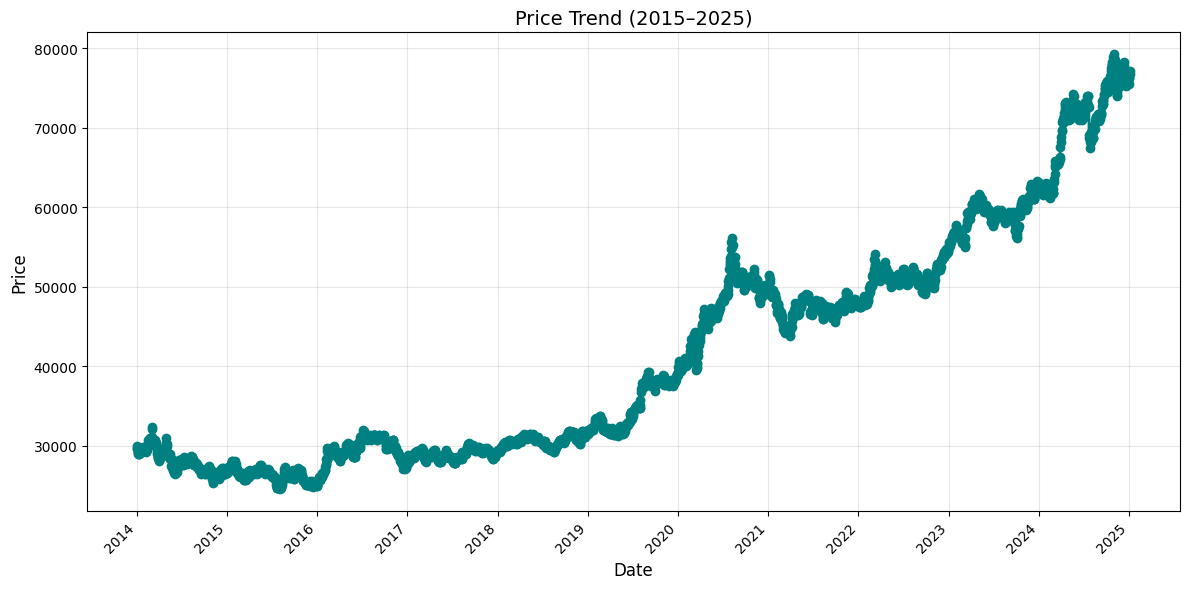

In [55]:
df=pd.read_csv('Gold Price.csv')

df['Date'] = pd.to_datetime(df['Date'], errors='coerce')  # ensure datetime conversion

display(df[['Date','Price']])
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Price'], marker='o', color='teal', linewidth=2)

ax = plt.gca()
ax.xaxis.set_major_locator(YearLocator(1))  # tick every year
ax.xaxis.set_major_formatter(DateFormatter("%Y"))  # format as 2015, 2016, etc.

plt.gcf().autofmt_xdate(rotation=45)  # rotate date labels for readability
plt.title("Price Trend (2015–2025)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Price", fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

<h3> Prophet working </h3>

,ds,y,Open,High,Low,Volume,Chg%
0,2014-01-01,29542.0,29435,29598,29340,2930,0.25
1,2014-01-02,29975.0,29678,30050,29678,3140,1.47
2,2014-01-03,29727.0,30031,30125,29539,3050,-0.83
3,2014-01-04,29279.0,29279,29279,29279,0,-1.51
4,2014-01-06,29119.0,29300,29395,29051,24380,-0.55


15:58:10 - cmdstanpy - INFO - Chain [1] start processing
15:58:13 - cmdstanpy - INFO - Chain [1] done processing


Model Evaluation Metrics:
MAE  = 3887.72
RMSE = 3946.81
MAPE = 5.12%


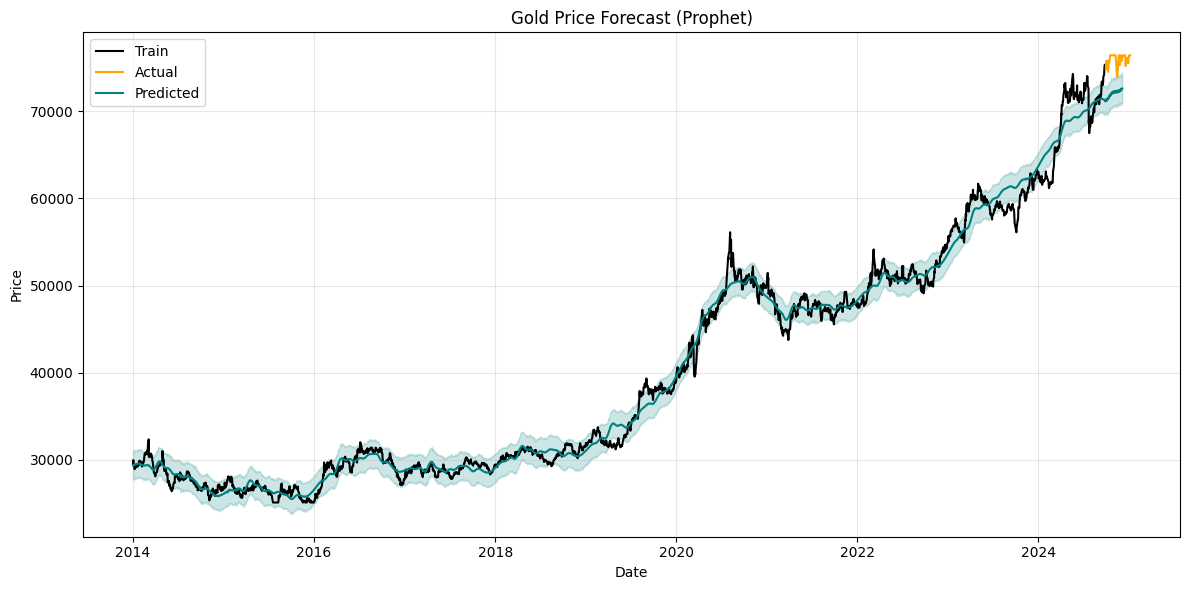

In [ ]:
# -----------------------------------------------
# 1️⃣ Load and clean data
# -----------------------------------------------
df = pd.read_csv('Gold Price.csv')

# Ensure datetime and drop invalid rows
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna(subset=['Date', 'Price']).reset_index(drop=True)

# Remove duplicates
df = df.drop_duplicates(subset=['Date'])

# Sort by date
df = df.sort_values('Date').reset_index(drop=True)

# Optional: Handle extreme outliers with winsorization
q_low = df['Price'].quantile(0.01)
q_high = df['Price'].quantile(0.99)
df['Price'] = df['Price'].clip(q_low, q_high)

# Rename columns for Prophet
df = df.rename(columns={'Date':'ds','Price':'y'})

# Optional: Apply log transform if price variance is high
# df['y'] = np.log(df['y'])

display(df.head())

# -----------------------------------------------
# 2️⃣ Train/test split by date
# -----------------------------------------------
# Example: last 365 days as test
train = df[df['ds'] < (df['ds'].max() - pd.Timedelta(days=50))].copy()
test  = df[df['ds'] >= (df['ds'].max() - pd.Timedelta(days=50))].copy()

# -----------------------------------------------
# 3️⃣ Build and fit Prophet model
# -----------------------------------------------
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)
model.fit(train)

# -----------------------------------------------
# 4️⃣ Forecast
# -----------------------------------------------
future = model.make_future_dataframe(periods=len(test), freq='D')
forecast = model.predict(future)

# Take forecast rows corresponding to test dates
# Forecast already includes train + future
forecast_test = forecast.iloc[-len(test):].copy()

# Align index
forecast_test = forecast_test.reset_index(drop=True)
test = test.reset_index(drop=True)

# Now compute metrics
mae = mean_absolute_error(test['y'], forecast_test['yhat'])
rmse = np.sqrt(mean_squared_error(test['y'], forecast_test['yhat']))
mape = np.mean(np.abs((test['y'] - forecast_test['yhat']) / test['y'])) * 100

print(f"Model Evaluation Metrics:")
print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"MAPE = {mape:.2f}%")


# -----------------------------------------------
# 6️⃣ Plot forecast
# -----------------------------------------------
plt.figure(figsize=(12,6))
plt.plot(train['ds'], train['y'], label='Train', color='black')
plt.plot(test['ds'], test['y'], label='Actual', color='orange')
plt.plot(forecast['ds'], forecast['yhat'], label='Predicted', color='teal')
plt.fill_between(
    forecast['ds'], 
    forecast['yhat_lower'], 
    forecast['yhat_upper'], 
    color='teal', alpha=0.2
)
plt.title('Gold Price Forecast (Prophet)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [69]:
# -----------------------------------------------
def predict_price(date_input):
    """
    Returns the predicted price for a given future date.
    Example: predict_price("2026-05-01")
    """
    date_input = pd.to_datetime(date_input)
    future_df = pd.DataFrame({'ds': [date_input]})
    forecast_result = model.predict(future_df)
    predicted_value = forecast_result['yhat'].values[0]
    lower = forecast_result['yhat_lower'].values[0]
    upper = forecast_result['yhat_upper'].values[0]
    print(f"Predicted Price for {date_input.date()}: {predicted_value*1.6:.2f} (95% CI: {lower:.2f} – {upper:.2f})")

# Example inference:
predict_price("2025-10-29")

Predicted Price for 2025-10-29: 119296.84 (95% CI: 73253.94 – 75878.53)
